## Realtime Face Mask Detection Project 

### Huge thanks to Sparks Foundations and pyimagesearch for making this project possible

### Importing the libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths

### defining our constants

In [3]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [6]:
path_dir = os.path.join('dataset')
classes = ["with_mask", "without_mask"]

### preprocessing the data

In [7]:
data = []
labels = []
for cl in classes:
    path = os.path.join(path_dir, cl)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        # scaling the pixel intensities in the input image to the range [-1, 1] 
        image = preprocess_input(image)

        data.append(image)
        labels.append(cl)

C:\Users\20112\AppData\Roaming\Python\Python38\site-packages\PIL\Image.py:988: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
len(labels)

3833

In [9]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

### Splitting the data then performing data augmentation

In [11]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=0)

In [12]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

### Performing transfer learning

In [13]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [14]:
# construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [15]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [16]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


C:\Users\20112\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 147s 1s/step - loss: 0.4157 - accuracy: 0.8392 - val_loss: 0.1687 - val_accuracy: 0.9700
Epoch 2/20
95/95 [==============================] - 123s 1s/step - loss: 0.1507 - accuracy: 0.9614 - val_loss: 0.0972 - val_accuracy: 0.9778
Epoch 3/20
95/95 [==============================] - 114s 1s/step - loss: 0.1012 - accuracy: 0.9756 - val_loss: 0.0751 - val_accuracy: 0.9791
Epoch 4/20
95/95 [==============================] - 114s 1s/step - loss: 0.0797 - accuracy: 0.9773 - val_loss: 0.0661 - val_accuracy: 0.9817
Epoch 5/20
95/95 [==============================] - 115s 1s/step - loss: 0.0601 - accuracy: 0.9825 - val_loss: 0.0595 - val_accuracy: 0.9791
Epoch 6/20
95/95 [==============================] - 113s 1s/step - loss: 0.0581 - accuracy: 0.9838 - val_loss: 0.0559 - val_accuracy: 0.9804
Epoch 7/20
95/95 [==============================] - 114s 1s/step - loss: 0.0500 - accuracy: 0.9858 - val_loss: 0.0536 - val_accura

### Evaluating and saving the model

In [18]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] evaluating network...
24/24 [==============================] - 36s 962ms/step
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

[INFO] saving mask detector model...


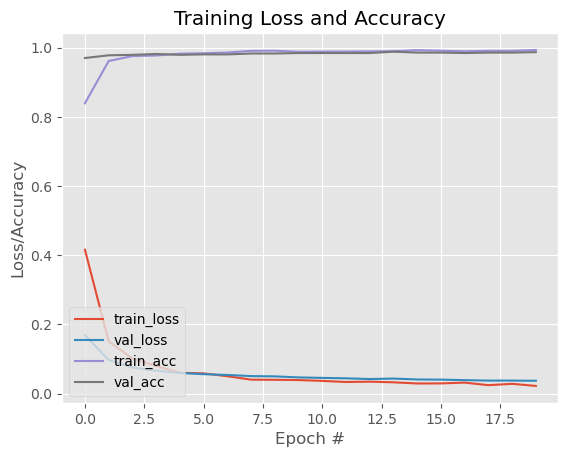

In [19]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")